# **Put-call ratio forecasting**

In [1]:
# Necessary imports

import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings

warnings.filterwarnings('ignore')

import random
random.seed(123)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_time = pd.read_csv('Test_dataset2.csv')
df_time.head()

,Stock Index,10-Aug,11-Aug,12-Aug,13-Aug,14-Aug,15-Aug
0,AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
1,AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
2,AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
3,AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
4,AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519


In [3]:
X_time = df_time.drop(columns = 'Stock Index')

# Imputing null-values carefully based on the behaviour shown by its nearest neighbours

imputer = KNNImputer(n_neighbors=5)
X_time_imputed = pd.DataFrame(imputer.fit_transform(X_time), columns = X_time.columns)
X_time_imputed.head()

,10-Aug,11-Aug,12-Aug,13-Aug,14-Aug,15-Aug
0,0.80,0.660,0.77240,0.983224,0.901211,0.898368
1,0.86,0.732,0.85448,1.086645,1.017042,1.029258
2,0.93,0.816,0.95024,1.207302,1.152179,1.181962
3,1.09,1.008,1.16912,1.483091,1.461062,1.531000
4,1.17,1.104,1.27856,1.620986,1.615504,1.705519


In [4]:
X = X_time_imputed.T # Converting dates from columns to indices

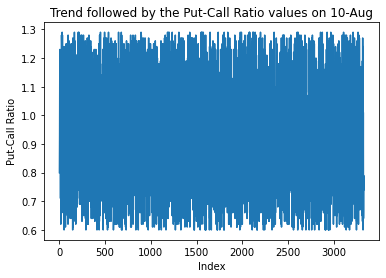

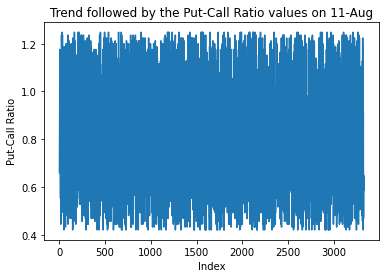

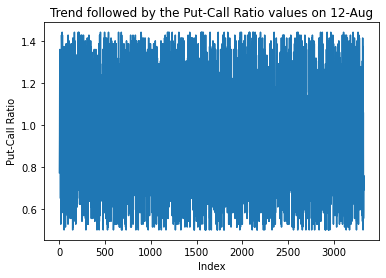

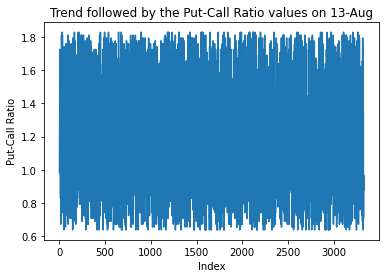

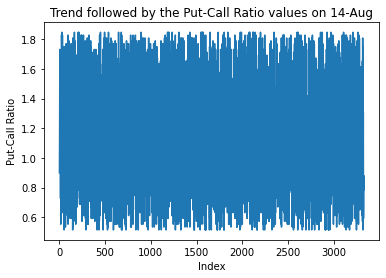

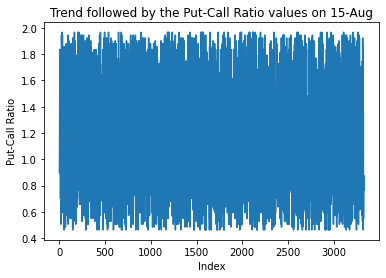

In [5]:
# Function to plot the trend shown by put-call ratio over the 6 given days

def trend_plot(X):
  for i in range(X.T.shape[0]):
    plt.plot(X.T.iloc[i])
    plt.xlabel('Index')
    plt.ylabel('Put-Call Ratio')
    plt.title('Trend followed by the Put-Call Ratio values on ' + str(X_time_imputed.columns[i]))
    plt.show()

trend_plot(X_time_imputed)

# Assumptions to be taken care of

Before going further with designing the model, certain assumptions mentioned below must be satisfied by the data. The assumptions being the following:

1. The put-call ratio must have a constant mean over all the days.

2. The put-call ratio must have a constant variance throughout the given 6 days.

3. The put-call ratio must also have a constant covariance throughout the given 6 days.

The above mentioned assumptions are important to be abided to because most algorithms work well given the above assumptions are satisfied.

# Augmented Dicky Fuller (ADF) Test 

The ADF test follows the following principles:

$H_0$ : $\mu$, $\sigma^2$ and Cov($X_1, X_2$) are varying; i.e. the data isn't stationary.

$H_1$ : $\mu$, $\sigma^2$ and Cov($X_1, X_2$) are constant; i.e. the data is stationary.

Let the value of the test-statistics be T, then the $H_0$ can be rejected if T > $q_{\alpha}$, where $q_{\alpha}$ is the 1 - $\alpha$ quantile of the asymptotic distribution of the test-statistic T. 

For our purpose let the cut-off $\alpha$ = 5%. Hence if the p-value > 5%, we may reject $H_0$ and happily move ahead.

In [6]:
# The augmented Dicky Fuller test to ensure that the above shown trend follows a stationary behaviour, with constant mean, std. and cvariance.

def ADF_test(X):
   
  # Augmented Dicky Fuller Test
  
  X.dropna(inplace = True)
  print('Results of the Augmented Dicky Fuller Test are: ')
  dftest = adfuller(X.iloc[0])
  print('ADF Statistic: %f' % dftest[0])
  print('p-value: %f' % dftest[1])
  print('Critical Values:')
  for key, value in dftest[4].items():
	  print('\t%s: %.3f' % (key, value))
  if dftest[1] > dftest[4]['5%']:
    print('Reject H_0 => The data points are stationary')
  else:
    print('Failed to reject H_0 => The data points aren\'t stationary')
ADF_test(X)

Results of the Augmented Dicky Fuller Test are: 
ADF Statistic: -56.461187
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H_0 => The data points are stationary


In [7]:
# Converting the string of dates into a column vector and replacing the index values with numerical values.

X.insert(0, 'ds', X.index) 
X.index = range(X.shape[0])

In [8]:
# Function to convert the string of numbers into their datetime format

def convert_datetime(X):
  date = []
  format = '%d-%b'
  for i in range(X.shape[0]):
    date.append(datetime.datetime.strptime(X['ds'][i], format))
  X['ds'] = date
  return X

In [9]:
# Calling the above function to replace the previous sting of dates with their timestamp form and again replacing the numeric index values with these converted dates

X = convert_datetime(X)
X.index = pd.to_datetime(X['ds'])
X = X.drop(columns='ds')

In [10]:
# Preparing train and validation datasets for testing the model that will be built further

train = X[:-1]
test = X[-1:]

# Scaling the dataset

scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Defining certain input values before hand

n_input = 1
n_features = 3331
epochs = 500

# Model

Since the data follows a sequencial pattern that is temporal in nature, we shall choose to go with a unidirectional LSTM architecture for designing our model.

In [11]:
# The LSTM model

class Model:
  def __init__(self, n_input, n_features):
    self.n_input = n_input
    self.n_features = n_features
  def fit(self, generator, epochs):
    model = Sequential()
    model.add(LSTM(32, activation = 'relu', input_shape=(self.n_input, self.n_features), return_sequences=True))
    model.add(LSTM(64, activation = 'relu', return_sequences=True))
    model.add(LSTM(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100))
    model.add(Dense(self.n_features))
    model.compile(optimizer = 'adam', loss = 'mse')
    print(model.summary())
    print('------------------------------------------')
    print('The Training is about to start!')
    print('------------------------------------------')
    model.fit_generator(generator, epochs=epochs)
    return model
  def prediction(self, X_scaled, model):
    pred_list = []
    batch = X_scaled[-self.n_input:].reshape((1, self.n_input, self.n_features))
    for i in range(self.n_input):
      pred_list.append(model.predict(batch)[0])
      batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis = 1)
    return pred_list

In [12]:
validation_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=6)
nn = Model(n_input=n_input, n_features=n_features)
model = nn.fit(generator=validation_generator, epochs=epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             430592    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 3331)              336431    
Total params: 903,571
Trainable params: 903,571
Non-trainable params: 0
__________________________________________________

In [13]:
# Function to convert the scaled output into its original form

def Inverse_Scaler(X):
  return scaler.inverse_transform(X)

validation_pred = Inverse_Scaler(nn.prediction(train_scaled, model))

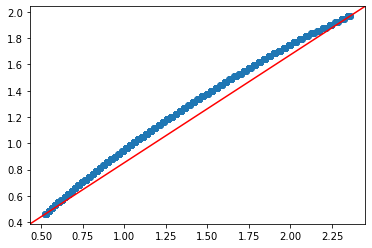

In [14]:
# A plot to compare the model's performance (the points must fall on a y=x line)

def Validation_Plot(pred, test):
  fig, ax = plt.subplots()
  plt.scatter(scaler.inverse_transform(pred), test)
  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  plt.show()

Validation_Plot(validation_pred, test)

In [15]:
# Preparing to re-train the previous model but now with the complete dataset

train = X

scaler.fit(train)
train_scaled = scaler.transform(train)

In [16]:
final_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=6)

# Training on the same model above
model_final = nn.fit(final_generator, epochs)

# Prediction
final_pred = Inverse_Scaler(nn.prediction(train_scaled, model_final)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 32)             430592    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 3331)              336431    
Total params: 903,571
Trainable params: 903,571
Non-trainable params: 0
________________________________________________

In [17]:
# Creating a dataframe for '16-Aug' and appending it with the above result

from pandas.tseries.offsets import DateOffset
add_date = [train.index[-1] + DateOffset(day = x) for x in range(16, 17)]
future_date = pd.DataFrame(index = add_date, columns = X.columns)

In [18]:
# Creating a dataframe for '16-Aug' with put-call ratio, for now, equal to 'Nan' 

df_predict = pd.DataFrame(final_pred, index = future_date[-n_input:].index, columns=train.columns)

pred_list = []
for i in range(n_features):
  pred_list.append(df_predict[i][0])

In [19]:
final_sub = pd.DataFrame({'Stock Index': df_time['Stock Index'], 'Stock Price': pred_list})
final_sub.head()

,Stock Index,Stock Price
0,AC3235,0.900567
1,AC3236,1.035279
2,AC3237,1.207457
3,AC3238,1.591781
4,AC3239,1.773449


In [20]:
# Submission

final_sub.to_csv('Put-call_ratio(16-Aug).csv', index=False)